In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Dataset"
os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['activity_labels.txt',
 '.ipynb_checkpoints',
 'test',
 'train',
 'activity_labels']

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  
from sklearn import metrics
import os

# Output classes to learn how to classify
LABELS = ["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"]

In [ ]:
import numpy as np
INPUT_SIGNAL_TYPES = ["acc_x_","acc_y_","acc_z_","gyro_x_","gyro_y_","gyro_z_",]

# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))
X_train = load_X(['train/X_train/'+ signal + "train.txt" for signal in INPUT_SIGNAL_TYPES])
X_test = load_X(['test/X_test/'+ signal + "test.txt" for signal in INPUT_SIGNAL_TYPES])

# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    return y_ - 1
y_train = load_y('train/'+ "y_train.txt")
y_test = load_y('test/' + "y_test.txt")

In [ ]:
import numpy as np
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep

# LSTM Neural Network's internal structure
n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)
# Training
learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training
# Some debugging info
print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 6) (2947, 1) 0.14890043 0.46668795
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
tf.reset_default_graph()

def LSTM_RNN(_X, _weights, _biases):
    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input])
    # new shape: (n_steps*batch_size, n_input)
    # ReLU activation
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0)
    # new shape: n_steps * (batch_size, n_hidden)
    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.compat.v1.nn.rnn_cell.BasicRNNCell(n_hidden)
    lstm_cell_2 = tf.compat.v1.nn.rnn_cell.BasicRNNCell(n_hidden)
    lstm_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell([lstm_cell_1, lstm_cell_2])
    # Get LSTM cell output
    outputs, states = tf.compat.v1.nn.static_rnn(lstm_cells, _X, dtype=tf.float32)
    # Get last time step's output feature for a "many-to-one" style classifier,
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']

def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index]

    return batch_s

In [ ]:
# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
# L2 loss prevents this overkill neural network to overfit the data
l2 = lambda_loss_amount * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()) 
# Softmax loss
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 
# Adam Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) 

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [ ]:
def one_hot(y_, n_classes=n_classes):
    # Function to encode neural one-hot output labels from number indexes
    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs,
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)

    # Evaluate network only at some steps for faster training:
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))

        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy],
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Training iter #1500:   Batch Loss = 5.703175, Accuracy = 0.057999998331069946
PERFORMANCE ON TEST SET: Batch Loss = 4.119187355041504, Accuracy = 0.12656939029693604
Training iter #30000:   Batch Loss = 1.495871, Accuracy = 0.6193333268165588
PERFORMANCE ON TEST SET: Batch Loss = 1.6224853992462158, Accuracy = 0.5663386583328247
Training iter #60000:   Batch Loss = 1.253124, Accuracy = 0.6513333320617676
PERFORMANCE ON TEST SET: Batch Loss = 1.398895502090454, Accuracy = 0.6345435976982117
Training iter #90000:   Batch Loss = 1.217737, Accuracy = 0.6779999732971191
PERFORMANCE ON TEST SET: Batch Loss = 1.3210086822509766, Accuracy = 0.6593145728111267
Training iter #120000:   Batch Loss = 1.138096, 

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


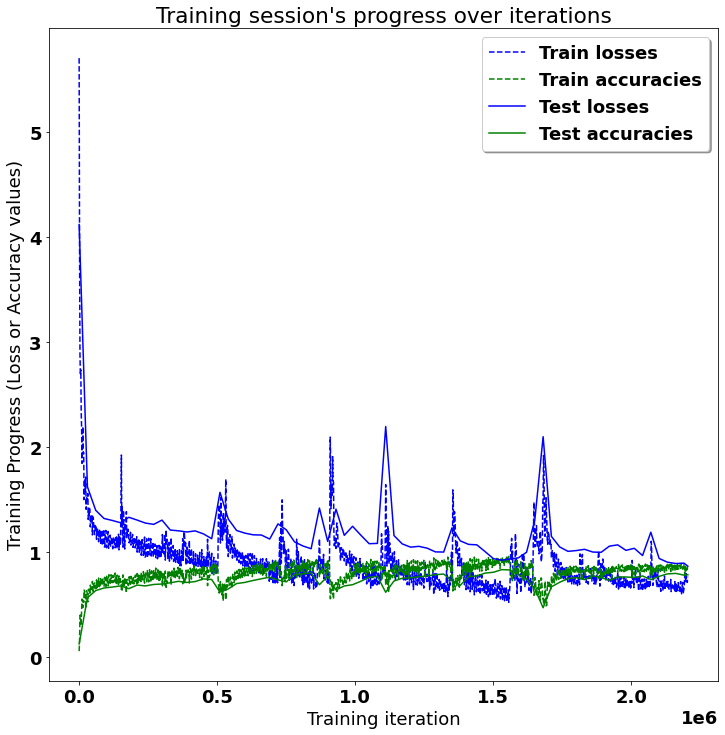

In [ ]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),"b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),"b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()


Testing Accuracy: 79.30098176002502%

Precision: 81.71840919662657%
Recall: 79.30098405157787%
f1_score: 79.1888411067198%

Confusion Matrix:
[[276 112 108   0   0   0]
 [ 31 406  33   0   1   0]
 [  7  30 383   0   0   0]
 [  2  25   0 411  53   0]
 [  6  75   0 100 351   0]
 [  0  26   1   0   0 510]]

Confusion matrix (normalised to % of total test data):
[[ 9.365457    3.8004751   3.664744    0.          0.          0.        ]
 [ 1.0519172  13.776723    1.1197829   0.          0.03393281  0.        ]
 [ 0.2375297   1.0179844  12.996266    0.          0.          0.        ]
 [ 0.06786563  0.8483203   0.         13.946385    1.798439    0.        ]
 [ 0.20359688  2.544961    0.          3.3932812  11.910418    0.        ]
 [ 0.          0.88225317  0.03393281  0.          0.         17.305735  ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


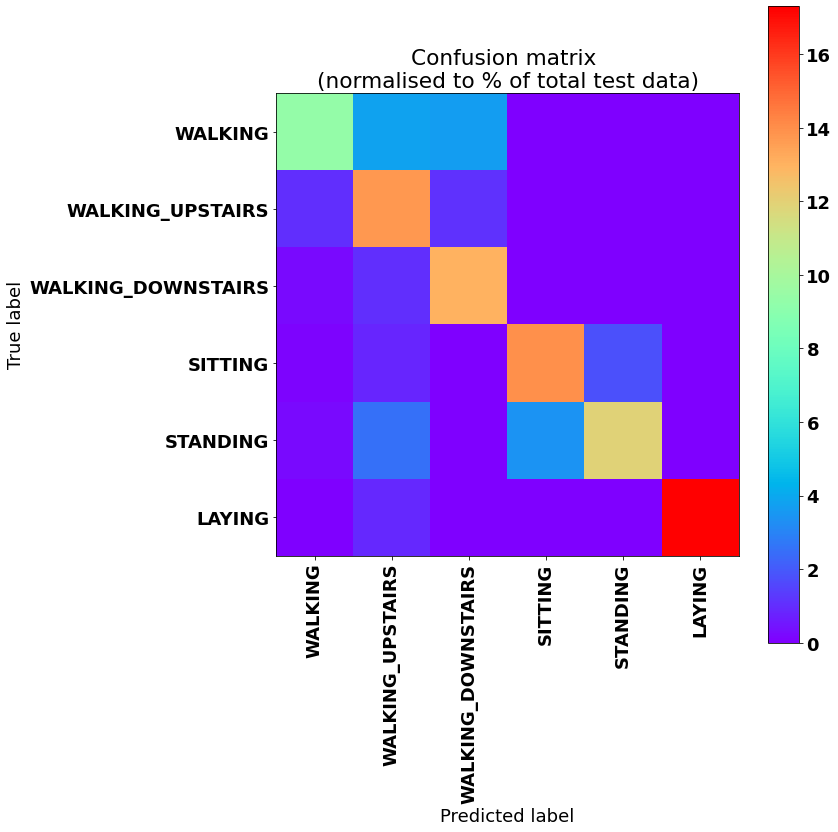

In [ ]:
# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix,
    interpolation='nearest',
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
